In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

In [2]:
from io_utils import load_matrices_from_dir, load_models
from scipy.sparse.linalg import norm

  Activating project at `~/My_Drive/Research/code/Dynamic-Selective-Protection/Pcg`


In [3]:
matrix = "cbuckle"
errorfree_iterations = 432

In [4]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<13681x13681 sparse matrix of type '<class 'numpy.float64'>'
	with 676515 stored elements in Compressed Sparse Column format>

In [5]:
chosen_models = {
    "bcsstk18": "RandomForestRegressor",
    "cbuckle": "KNeighborsRegressor"
}
model_path = f"./models/{matrix}/best_{chosen_models[matrix]}.pkl"
model = load_models([model_path])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_neighbors=10, p=1.8733986290581737))])

In [6]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                              for i in range(errorfree_iterations)])
df = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df["output"] = model.predict(df[["i", "2norm"]].to_numpy())
df.head()

,i,2norm,rowid,output
0,0.0,482.674452,0.0,1.009384
1,1.0,482.674452,0.0,1.009384
2,2.0,482.674452,0.0,1.009384
3,3.0,482.674452,0.0,1.007331
4,4.0,482.674452,0.0,0.998240


In [7]:
df_piv = df.pivot(index=["2norm", "rowid"], columns="i", values="output")

protections = df_piv.to_numpy()
print(protections.shape, mat.shape, 11948 * 432)
df_piv.head()

(13681, 432) (13681, 13681) 5161536


i                    0.0       1.0       2.0       3.0      4.0       5.0    \
2norm    rowid                                                                
3.566815 6841.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         1.0      1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         10262.0  1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         3422.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
3.571172 6949.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   

i                    6.0       7.0      8.0       9.0    ...     422.0  \
2norm    rowid                                           ...             
3.566815 6841.0   1.203226  1.212903  1.24956  1.250147  ...  0.996188   
         1.0      1.203226  1.212903  1.24956  1.250147  ...  0.996188   
         10262.0  1.203226  1.212903  1.24956  1.250147  ...  0.996188   
         3422.0   1.203226  1.212903  1.24956  1.250147  ...  0.996188   
3.571172 6949.0   1.203226  1.212903  1.24956  1.250147  ...  0.996188   

i                    423.0     424.0     425.0     426.0     427.0     428.0  \
2norm    rowid                                                                 
3.566815 6841.0   0.996188  0.996188  0.996188  0.996188  0.996188  0.996188   
         1.0      0.996188  0.996188  0.996188  0.996188  0.996188  0.996188   
         10262.0  0.996188  0.996188  0.996188  0.996188  0.996188  0.996188   
         3422.0   0.996188  0.996188  0.996188  0.996188  0.996188  0.996188   
3.571172 6949.0   0.996188  0.996188  0.996188  0.996188  0.996188  0.996188   

i                    429.0     430.0     431.0  
2norm    rowid                                  
3.566815 6841.0   0.996188  0.996188  0.996188  
         1.0      0.996188  0.996188  0.996188  
         10262.0  0.996188  0.996188  0.996188  
         3422.0   0.996188  0.996188  0.996188  
3.571172 6949.0   0.996188  0.996188  0.996188  

[5 rows x 432 columns]

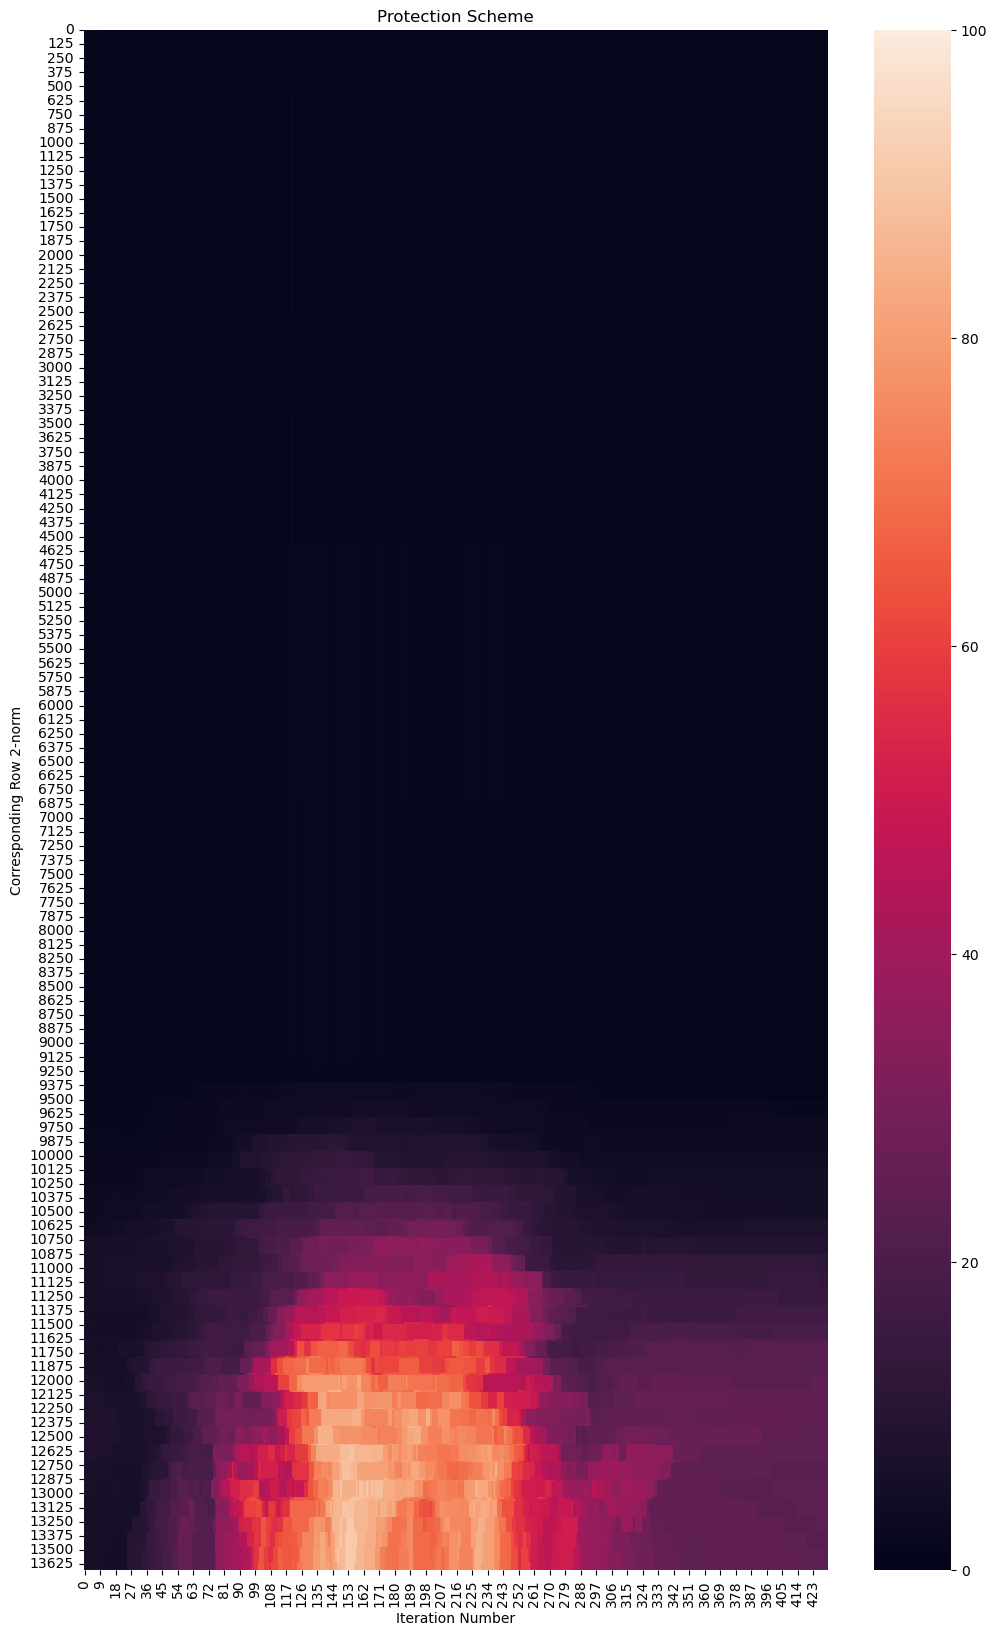

In [8]:
plt.gcf().set_size_inches(12, 20)
plt.gcf().set_dpi(100)
heatmap(protections, vmin=0, vmax=100)
plt.title("Protection Scheme")
plt.xlabel("Iteration Number")
plt.ylabel("Corresponding Row 2-norm")
plt.savefig(f"./figures/{matrix}/iter_r2n_output.png")
plt.show()

In [9]:
df_piv = df.pivot(index=["rowid"], columns="i", values="output")

protections = df_piv.to_numpy()
print(protections.shape, mat.shape, 11948 * 432)
df_piv.head()

(13681, 432) (13681, 13681) 5161536


i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,422.0,423.0,424.0,425.0,426.0,427.0,428.0,429.0,430.0,431.0
rowid,,,,,,,,,,,,,,,,,,,,,
0.0,1.009384,1.009384,1.009384,1.007331,0.998240,1.012610,1.041056,1.043402,1.043109,1.026686,...,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015
1.0,1.174487,1.174487,1.174487,1.214663,1.174780,1.207918,1.203226,1.212903,1.249560,1.250147,...,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188
2.0,1.174487,1.174487,1.174487,1.214370,1.246334,1.208798,1.261290,1.266862,1.288270,1.250147,...,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188,0.996188
3.0,1.010850,1.011730,1.009384,1.007625,0.998240,1.012610,1.041056,1.039883,1.041935,1.040762,...,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015,0.995015
4.0,6.334311,6.334311,6.334311,6.334311,6.334311,6.334311,6.334311,6.334311,6.334311,6.334311,...,24.326979,24.326979,24.326979,24.326979,24.326979,24.326979,24.326979,24.326979,24.326979,24.326979


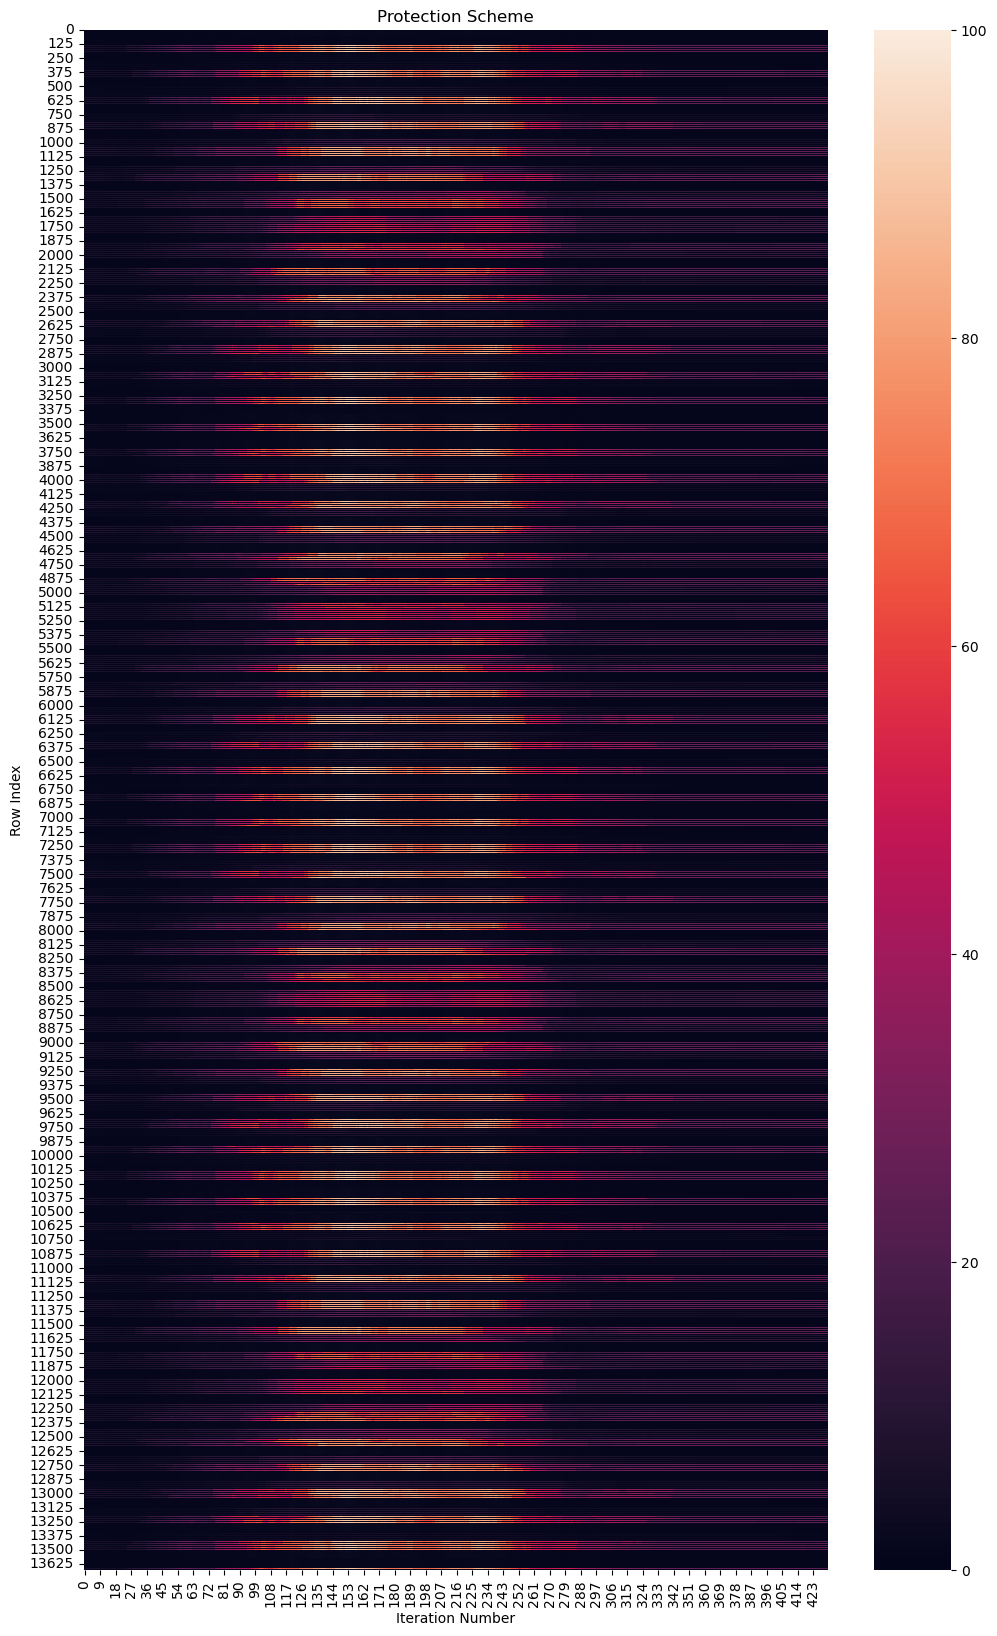

In [10]:
plt.gcf().set_size_inches(12, 20)
plt.gcf().set_dpi(100)
heatmap(protections, vmin=0, vmax=100)
plt.title("Protection Scheme")
plt.xlabel("Iteration Number")
plt.ylabel("Row Index")
plt.savefig(f"./figures/{matrix}/iter_row_output.png")
plt.show()